<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Keypoint Detection using Mask R-CNN

In this notebook, we will introduce keypoint detection. Keypoints are meaningful points of an object detected in an image. We first will demonstrate how to use a provided model for human body pose detection based on a pretrained [Keypoint R-CNN](https://arxiv.org/abs/1703.06870) model. Afterwards, we will show how to train on your own keypoint dataset, e.g. to detect where the top or bottom of an object is independent of it's rotation in the image.

## Initialization

In [1]:
# imports
from PIL import Image
import matplotlib.pyplot as plt
import scrapbook as sb
import urllib.request
import torch
import torchvision

# utility
import sys
sys.path.append("../../")
from utils_cv.common.data import data_path, unzip_url
from utils_cv.common.gpu import is_windows, which_processor
from utils_cv.detection.data import Urls, coco_labels
from utils_cv.detection.dataset import DetectionDataset
from utils_cv.detection.keypoint import COCO_keypoint_meta
from utils_cv.detection.model import DetectionLearner, get_pretrained_keypointrcnn
from utils_cv.detection.plot import plot_detections, PlotSettings

# Change matplotlib backend so that plots are shown for windows
if is_windows():
    plt.switch_backend("TkAgg")

print(f"TorchVision: {torchvision.__version__}")
which_processor()

TorchVision: 0.4.0
('cudart64_100', 0)
Torch is using GPU: Tesla V100-PCIE-16GB


In [2]:
# ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Next, set some model runtime parameters.

In [3]:
DATA_PATH = unzip_url(Urls.fridge_objects_keypoint_milk_bottle_path, exist_ok=True)
EPOCHS = 10
LEARNING_RATE = 0.005
IM_SIZE = 500
THRESHOLD = 0.5  # discard all detections with confidence score below this threshold

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using torch device: {device}")

Using torch device: cuda


## Prediction with Pre-trained Model

### Preparation

We will be using this image to show the output of the human pose detection model:

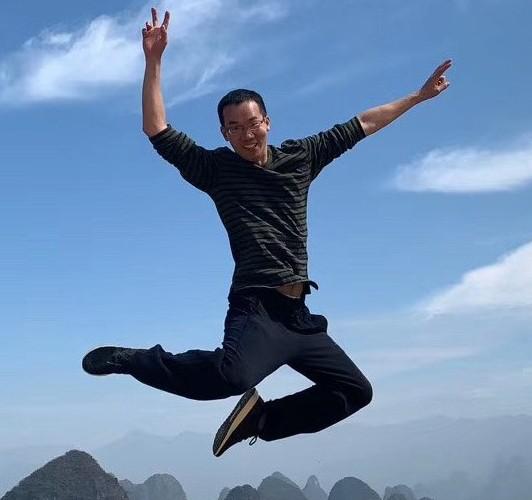

In [4]:
# download image
im_url = "https://cvbp.blob.core.windows.net/public/datasets/object_detection/keypoint_detection.jpg"
im_path = data_path() / im_url.split('/')[-1]
urllib.request.urlretrieve(im_url, im_path)

# show image
Image.open(im_path)

Similar to the [01_training_introduction notebook](https://render.githubusercontent.com/view/01_training_introduction.ipynb), we create a `DetectionLearner` object using `get_pretrained_keypointrcnn()` to get the pretrained pose estimation model.

In [5]:
# get pretrained keypoint rcnn model
person_detector = DetectionLearner(
    model=get_pretrained_keypointrcnn(min_size=IM_SIZE, max_size=IM_SIZE),
    labels=coco_labels()[1:],
    device=device,
)

The pretrained model is built on the [COCO train2017 dataset (118K/18GB)](http://images.cocodataset.org/zips/train2017.zip) with 17 annotated human body keypoints.

In [6]:
COCO_keypoint_meta["labels"]

['nose',
 'left_eye',
 'right_eye',
 'left_ear',
 'right_ear',
 'left_shoulder',
 'right_shoulder',
 'left_elbow',
 'right_elbow',
 'left_wrist',
 'right_wrist',
 'left_hip',
 'right_hip',
 'left_knee',
 'right_knee',
 'left_ankle',
 'right_ankle']

Some keypoints share an edge, this information is used for visualization.

In [7]:
COCO_keypoint_meta["skeleton"]

[[15, 13],
 [13, 11],
 [16, 14],
 [14, 12],
 [11, 12],
 [5, 11],
 [6, 12],
 [5, 6],
 [5, 7],
 [6, 8],
 [7, 9],
 [8, 10],
 [1, 2],
 [0, 1],
 [0, 2],
 [1, 3],
 [2, 4],
 [3, 5],
 [4, 6]]

### Prediction

The results from `DetectionLearner.predict()` is a Dictionary containing `det_bboxes` and `keypoints`.

In [8]:
# predict
detections = person_detector.predict(im_path, threshold=THRESHOLD)
detections["det_bboxes"]

[{Bbox object: [left=90, top=25, right=461, bottom=456] | <person> | label:1 | path:C:\Users\pabuehle\Desktop\ComputerVision\data\keypoint_detection.jpg} | score: 0.9994146823883057]

A keypoint is represented by its x and y coordinate as well as visibility in the image.  `0` means invisible.

In [9]:
detections["keypoints"]

array([[[247.23952 , 134.06909 ,   1.      ],
        [254.67926 , 124.49359 ,   1.      ],
        [235.54851 , 126.621475,   1.      ],
        [268.4959  , 122.3657  ,   1.      ],
        [223.85751 , 134.06909 ,   1.      ],
        [300.3805  , 156.41193 ,   1.      ],
        [216.41776 , 171.30714 ,   1.      ],
        [362.024   , 125.55753 ,   1.      ],
        [157.96269 , 133.00514 ,   1.      ],
        [419.41623 ,  94.70315 ,   1.      ],
        [150.52298 ,  62.78482 ,   1.      ],
        [296.1292  , 318.13144 ,   1.      ],
        [255.74207 , 317.0675  ,   1.      ],
        [352.45865 , 388.35175 ,   1.      ],
        [235.54851 , 373.45654 ,   1.      ],
        [262.119   , 418.14224 ,   1.      ],
        [262.119   , 416.01434 ,   1.      ]]], dtype=float32)

### Visualization

We can use `plot_detections()` to visualize the predicted bounding boxes and keypoints.  It takes an optional parameter `keypoint_meta` which is dictionary containing `"skeleton"` to specify how to connect the keypoints with edges.

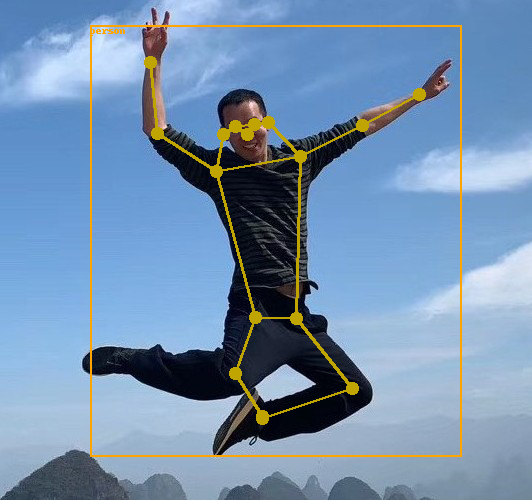

In [10]:
# plot
plot_detections(detections, keypoint_meta=COCO_keypoint_meta)

## Tuning with Custom Dataset

In the example above, we used a pre-trained model for pose estimation. We will now show how to train a model to find custom keypoints on a milk bottle. One can also train to detect keypoints on multiple objects at the same time (e.g. can, bottle, etc) as long as the number of keypoints is similar for all objects (e.g. top and bottom of each object).

### Browse and Prepare the Dataset

We are going to use the `Urls.fridge_objects_keypoint_milk_bottle_path` dataset for illustration. The dataset has already been downloaded and unzipped into `DATA_PATH`. This dataset includes 85 images of annotated milk bottles.

```
odFridgeObjectsMilkbottleKeypoint/
├── annotations
│   ├── 105.xml
│   ├── 106.xml
│   ├── ...
│   └── 9.xml
└── images
    ├── 105.jpg
    ├── 106.jpg
    ├── ...
    └── 9.jpg
```

As we have seen in the [01_training_introduction notebook](01_training_introduction.ipynb), the annotations are of [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/) format.  The difference to before is the additional information on keypoints.

```xml
<annotation>
        <folder>images</folder>
        <filename>105.jpg</filename>
        <path>../images/105.jpg</path>
        <source>
                <database>Unknown</database>
        </source>
        <size>
                <width>499</width>
                <height>666</height>
                <depth>3</depth>
        </size>
        <segmented>0</segmented>
        <object>
                <name>milk_bottle</name>
                <pose>Unspecified</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                        <xmin>142</xmin>
                        <ymin>257</ymin>
                        <xmax>395</xmax>
                        <ymax>463</ymax>
                </bndbox>
                <keypoints>
                        <lid_left_top>
                                <x>151</x>
                                <y>303</y>
                        </lid_left_top>
                        <lid_right_top>
                                <x>179</x>
                                <y>261</y>
                        </lid_right_top>
                        <left_bottom>
                                <x>311</x>
                                <y>455</y>
                        </left_bottom>
                        <right_bottom>
                                <x>381</x>
                                <y>350</y>
                        </right_bottom>
                </keypoints>
        </object>
</annotation>
```

To load the data, we can use the `DetectionDataset`class that knows how to extract annotation information from the Pascal VOC format, including keypoints. The  parameter `keypoint_meta` is used to specifying the meta data for the keypoints we are going to predict. The keypoints meta data should be a dictionary with keys `labels`, `skeleton` and `hflip_inds`.  The key `labels` referes to the names of the keypoints, `skeleton` defines for plotting which keypoints should be connected, and `hflip_inds` indicates what keypoints is transformed into which when the image is flipped horizontally during training (e.g. left becomes right).

For our dataset, we annotated 6 keypoints on milk bottles. 

In [11]:
milkbottle_keypoint_meta = {
    "labels": [
        "lid_left_top",
        "lid_right_top",
        "lid_left_bottom",
        "lid_right_bottom",
        "left_bottom",
        "right_bottom",
    ],
    "skeleton": [[0, 1], [0, 2], [1, 3], [2, 3], [2, 4], [3, 5], [4, 5]],
    "hflip_inds": [1, 0, 3, 2, 5, 4], 
}

There are 85 images, of which 69 are for training.


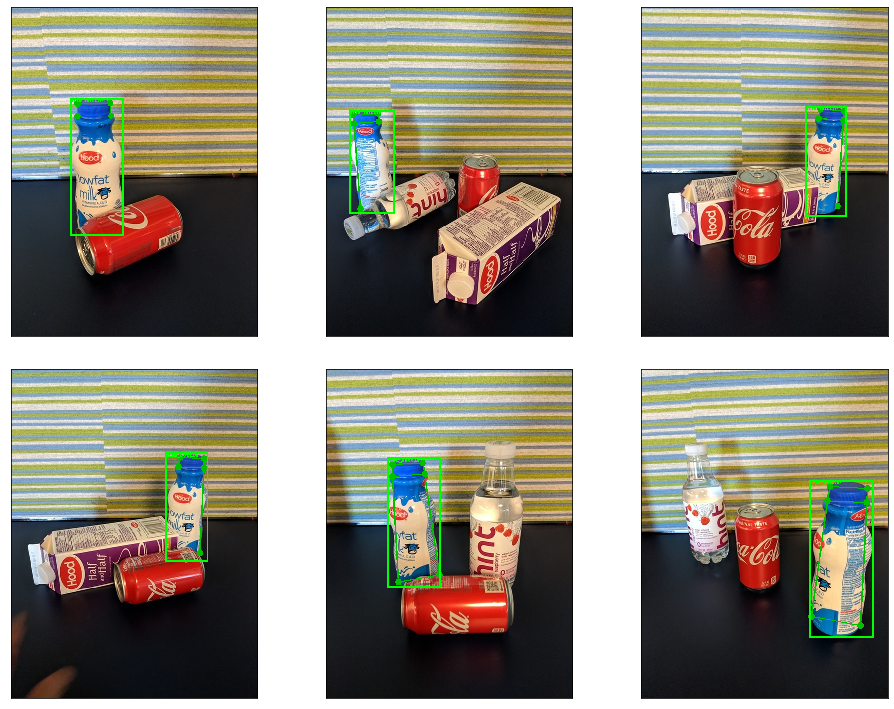

In [12]:
data = DetectionDataset(
    root=DATA_PATH, 
    keypoint_meta=milkbottle_keypoint_meta,
    train_pct=0.8,
)
print(f"There are {len(data)} images, of which {len(data.train_ds)} are for training.")
data.show_ims(rows=2, seed=168)

Note above that some keypoints in images are occluded and hence not annotated.

### Re-train

The model is now trained on our dataset by finetuning an ImageNet pre-trained model.

In [13]:
# train
model = get_pretrained_keypointrcnn(
    num_classes = 2,  # __background__ and milk_bottle
    num_keypoints = len(milkbottle_keypoint_meta["labels"]),
)
detector = DetectionLearner(dataset=data, model=model, device=device)
detector.fit(epochs=EPOCHS, lr=LEARNING_RATE, print_freq=30, skip_evaluation=True)

Epoch: [0]  [ 0/35]  eta: 0:00:30  lr: 0.000152  loss: 8.8974 (8.8974)  loss_classifier: 0.7597 (0.7597)  loss_box_reg: 0.0430 (0.0430)  loss_keypoint: 8.0666 (8.0666)  loss_objectness: 0.0221 (0.0221)  loss_rpn_box_reg: 0.0059 (0.0059)  time: 0.8750  data: 0.0937  max mem: 2492
Epoch: [0]  [30/35]  eta: 0:00:01  lr: 0.004559  loss: 6.4606 (7.3838)  loss_classifier: 0.0924 (0.2578)  loss_box_reg: 0.0845 (0.0849)  loss_keypoint: 6.3106 (7.0301)  loss_objectness: 0.0015 (0.0062)  loss_rpn_box_reg: 0.0040 (0.0048)  time: 0.3479  data: 0.0986  max mem: 2825
Epoch: [0]  [34/35]  eta: 0:00:00  lr: 0.005000  loss: 5.9387 (7.0331)  loss_classifier: 0.0767 (0.2365)  loss_box_reg: 0.0845 (0.0842)  loss_keypoint: 5.7740 (6.7014)  loss_objectness: 0.0019 (0.0064)  loss_rpn_box_reg: 0.0034 (0.0046)  time: 0.3380  data: 0.0932  max mem: 2825
Epoch: [0] Total time: 0:00:12 (0.3600 s / it)
Epoch: [1]  [ 0/35]  eta: 0:00:12  lr: 0.005000  loss: 3.3724 (3.3724)  loss_classifier: 0.0862 (0.0862)  loss_bo

Epoch: [9]  [ 0/35]  eta: 0:00:12  lr: 0.000500  loss: 0.8712 (0.8712)  loss_classifier: 0.0111 (0.0111)  loss_box_reg: 0.0043 (0.0043)  loss_keypoint: 0.8545 (0.8545)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0013 (0.0013)  time: 0.3604  data: 0.0937  max mem: 2831
Epoch: [9]  [30/35]  eta: 0:00:01  lr: 0.000500  loss: 1.1316 (1.2090)  loss_classifier: 0.0140 (0.0157)  loss_box_reg: 0.0095 (0.0096)  loss_keypoint: 1.1170 (1.1805)  loss_objectness: 0.0001 (0.0012)  loss_rpn_box_reg: 0.0015 (0.0020)  time: 0.3554  data: 0.0932  max mem: 2831
Epoch: [9]  [34/35]  eta: 0:00:00  lr: 0.000500  loss: 1.1937 (1.2154)  loss_classifier: 0.0152 (0.0166)  loss_box_reg: 0.0095 (0.0099)  loss_keypoint: 1.1567 (1.1858)  loss_objectness: 0.0001 (0.0011)  loss_rpn_box_reg: 0.0015 (0.0019)  time: 0.3514  data: 0.0955  max mem: 2831
Epoch: [9] Total time: 0:00:12 (0.3552 s / it)


### Prediction

Now we will do keypint detection on the first test image of milk bottle.

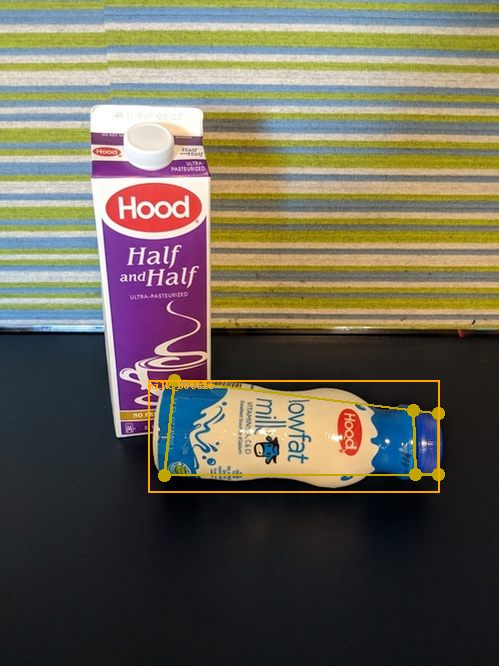

In [14]:
im_path = data.test_ds.dataset.im_paths[0]
detections = detector.predict(im_path, threshold=THRESHOLD)
plot_detections(detections, keypoint_meta=milkbottle_keypoint_meta)

### Further examples

Another example we provide is to identify just two keypoints (top and bottom) but of 4 different objects `{can, carton, milk bottle, water bottle}`. For this example, simply change the `DATA_PATH` and `keypoint_meta` variables to these values: 

```python
DATA_PATH = unzip_url(Urls.fridge_objects_keypoint_top_bottom_path, exist_ok=True)
keypoint_meta = {
    "labels": ["top", "bottom"],
    "skeleton": [[0, 1]],
    "hflip_inds": [0, 1],
}
```

The output of the trained model then looks like this:

<img src="media/keypoints_top_bottom_result.jpg" width="400px" />

In [15]:
# preserve some of the notebook outputs
sb.glue("keypoints", detections["keypoints"].tolist())
sb.glue("bboxes", [str(x) for x in detections["det_bboxes"]])

## Conclusion

In this notebook, we used the pretrained keypoint model based on Mask R-CNN for human pose estimation, and demonstrated how to tune the model to detect custom keypoints.